<a href="https://colab.research.google.com/github/marilynbraojos/transformer_demo/blob/main/gps2309.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit: Oliver S. from Toward Data Science

In [4]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [5]:
data = np.load('correction_data.npz')
data

NpzFile 'correction_data.npz' with keys: indices, y

In [6]:
clock_correction = data['y']
clock_correction

array([0.00017834, 0.00017834, 0.00017834, ..., 0.00017917, 0.00017917,
       0.00017917])

In [7]:
n_reps = 50

In [8]:
y_replicated = np.tile(clock_correction, n_reps)
y_replicated
len(y_replicated)

1637050

In [9]:
np.savez('replicated_file.npz', y=y_replicated)

In [10]:
less_points = y_replicated[::100]
data_reshaped = less_points.reshape(-1, 1)

In [11]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_reshaped)

In [12]:
#scaler = MinMaxScaler()
#data_scaled = scaler.fit_transform(data_reshaped)

In [13]:
data_scaled[:,0]

array([-1.70860955, -1.68333744, -1.65809683, ...,  0.56617176,
        0.82947998,  1.13415574])

In [14]:
np.savez('short_file.npz', y=data_scaled[:,0])

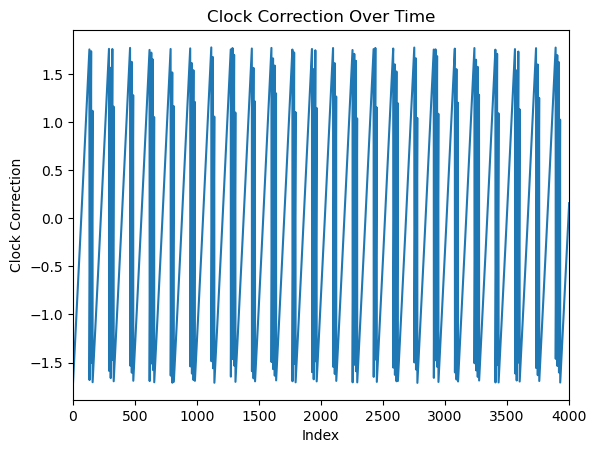

In [15]:
# Plotting with custom indices as x-axis

plt.plot(data_scaled)
plt.xlabel('Index')
plt.ylabel('Clock Correction')
plt.title('Clock Correction Over Time')
plt.xlim(0, 4000)  # Adjust the x-axis limit as needed
plt.show()

In [16]:
def split_sequence(
    sequence: np.ndarray, ratio: float = 0.7
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Splits a sequence into 2 (3) parts, as is required by our transformer
    model.

    Assume our sequence length is L, we then split this into src of length N
    and tgt_y of length M, with N + M = L.
    src, the first part of the input sequence, is the input to the encoder, and we
    expect the decoder to predict tgt_y, the second part of the input sequence.
    In addition we generate tgt, which is tgt_y but "shifted left" by one - i.e. it
    starts with the last token of src, and ends with the second-last token in tgt_y.
    This sequence will be the input to the decoder.

    Args:

        sequence: batched input sequences to split [bs, seq_len, num_features]
        ratio: split ratio, N = ratio * L

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: src, tgt, tgt_y
    """
    src_end = int(sequence.shape[1] * ratio)
    # [bs, src_seq_len, num_features]
    src = sequence[:, :src_end]
    # [bs, tgt_seq_len, num_features]
    tgt = sequence[:, src_end - 1 : -1]
    # [bs, tgt_seq_len, num_features]
    tgt_y = sequence[:, src_end:]

    return src, tgt, tgt_y

In [17]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html,
# only modified to account for "batch first"

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000) -> None:
      """
      Args:
        d_model (int): Dimension of the model (embedding dimension)
        dropout (float, optional): Dropout probability. Default is 0.1.
        max_len (int, optional): Maximum length of input sequences. Default is 5000.

      Attributes:
        pe (torch.Tensor): Positional encoding tensor. Shape: (1, max_len, d_model)

      Returns:
        torch.Tensor: input tensor with added positional encoding.

      """
      super().__init__()
      self.dropout = torch.nn.Dropout(p=dropout)

      position = torch.arange(max_len).unsqueeze(1)                           # 1-D tensor from 0 to max_len -1. Unsqueeze "adds" a superficial 1 dim.
      div_term = torch.exp(
          torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
      )
      pe = torch.zeros(1, max_len, d_model)
      pe[0, :, 0::2] = torch.sin(position * div_term)
      pe[0, :, 1::2] = torch.cos(position * div_term)
      self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      """Adds positional encoding to the given tensor.

      Args:
          x: tensor to add PE to [bs, seq_len, embed_dim]

      Returns:
          torch.Tensor: tensor with PE [bs, seq_len, embed_dim]
      """
      x = x + self.pe[:, : x.size(1)]
      return self.dropout(x)

In [18]:
class TransformerWithPE(torch.nn.Module):
    def __init__(
        self, in_dim: int, out_dim: int, embed_dim: int, num_heads: int, num_layers: int
    ) -> None:
        """
        Initializes a transformer model with positional encoding.

        Args:
            in_dim: number of input features
            out_dim: number of features to predict
            embed_dim: embed features to this dimension
            num_heads: number of transformer heads
            num_layers: number of encoder and decoder layers
        """
        super().__init__()

        self.positional_encoding = PositionalEncoding(embed_dim)

        # transform input features into embedded features
        self.encoder_embedding = torch.nn.Linear(
            in_features=in_dim, out_features=embed_dim
        )
        self.decoder_embedding = torch.nn.Linear(
            in_features=out_dim, out_features=embed_dim
        )

        # map output into output dimension
        self.output_layer = torch.nn.Linear(in_features=embed_dim, out_features=out_dim)


        self.transformer = torch.nn.Transformer(
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            d_model=embed_dim,
            batch_first=True,
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        """Forward function of the model.

        Args:
            src: input sequence to the encoder [bs, src_seq_len, num_features]
            tgt: input sequence to the decoder [bs, tgt_seq_len, num_features]

        Returns:
            torch.Tensor: predicted sequence [bs, tgt_seq_len, feat_dim]
        """
        # if self.train:
        # Add noise to decoder inputs during training
        # tgt = tgt + torch.normal(0, 0.1, size=tgt.shape).to(tgt.device)

        # Embed encoder input and add positional encoding.
        # [bs, src_seq_len, embed_dim]
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        # Generate mask to avoid attention to future outputs.
        # [tgt_seq_len, tgt_seq_len]
        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(tgt.shape[1])
        # Embed decoder input and add positional encoding.
        # [bs, tgt_seq_len, embed_dim]
        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        # Get prediction from transformer and map to output dimension.
        # [bs, tgt_seq_len, embed_dim]
        pred = self.transformer(src, tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)

        return pred                                                             # return predicted sequence


    def infer(self, src: torch.Tensor, tgt_len: int) -> torch.Tensor:
        """Runs inference with the model, meaning: predicts future values
        for an unknown sequence.
        For this, iteratively generate the next output token while
        feeding the already generated ones as input sequence to the decoder.

        Args:
            src: input to the encoder [bs, src_seq_len, num_features]
            tgt_len: desired length of the output

        Returns:
            torch.Tensor: inferred sequence
        """
        output = torch.zeros((src.shape[0], tgt_len + 1, src.shape[2])).to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = self.forward(src, output)[:, i]

        return output[:, 1:]

In [244]:
def load_and_partition_data(
    data_path: Path, seq_length: int = 100
) -> tuple[np.ndarray, int]:
    """Loads the given data and paritions it into sequences of equal length.

    Args:
        data_path: path to the dataset
        sequence_length: length of the generated sequences

    Returns:
        tuple[np.ndarray, int]: tuple of generated sequences and number of
            features in dataset
    """
    data = np.load(data_path)
    num_features = len(data.keys())

    # Check that each feature provides the same number of data points
    data_lens = [len(data[key]) for key in data.keys()]
    assert len(set(data_lens)) == 1

    num_sequences = data_lens[0] // seq_length
    sequences = np.empty((num_sequences, seq_length, num_features))

    for i in range(0, num_sequences):
        # [sequence_length, num_features]
        sample = np.asarray(
            [data[key][i * seq_length : (i + 1) * seq_length] for key in data.keys()]
        ).swapaxes(0, 1)
        sequences[i] = sample

    return sequences, num_features


def make_datasets(sequences: np.ndarray) -> tuple[TensorDataset, TensorDataset]:
    """Create train and test dataset.

    Args:
        sequences: sequences to use [num_sequences, sequence_length, num_features]

    Returns:
        tuple[TensorDataset, TensorDataset]: train and test dataset
    """
    # Split sequences into train and test split
    train, test = train_test_split(sequences, test_size=0.2)
    return TensorDataset(torch.Tensor(train)), TensorDataset(torch.Tensor(test))


def visualize(
    src: torch.Tensor,
    tgt: torch.Tensor,
    # 529 pred: torch.Tensor,
    pred_infer: torch.Tensor,
    idx=0,
) -> None:
    """Visualizes a given sample including predictions.

    Args:
        src: source sequence [bs, src_seq_len, num_features]
        tgt: target sequence [bs, tgt_seq_len, num_features]
        pred: prediction of the model [bs, tgt_seq_len, num_features]
        pred_infer: prediction obtained by running inference
            [bs, tgt_seq_len, num_features]
        idx: batch index to visualize
    """
    
    x = np.arange(src.shape[1] + tgt.shape[1])
    src_len = src.shape[1]

    # 529 commented out
    # plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
    # plt.plot(x[src_len:], tgt[idx].cpu().detach(), "go-", label="tgt")
    # # 529 plt.plot(x[src_len:], pred[idx].cpu().detach(), "ro-", label="pred")
    # plt.plot(x[src_len:], pred_infer[idx].cpu().detach(), "yo-", label="pred_infer")

    plt.plot(x[:src_len], scaler.inverse_transform(src[idx].cpu().detach()), "bo-", label="src")
    plt.plot(x[src_len:], scaler.inverse_transform(tgt[idx].cpu().detach()), "go-", label="tgt")
    # 529 plt.plot(x[src_len:], pred[idx].cpu().detach(), "ro-", label="pred")
    plt.plot(x[src_len:], scaler.inverse_transform(pred_infer[idx].cpu().detach()), "yo-", label="pred_infer")

    plt.legend()
    plt.show()
    plt.clf()


def split_sequence(
    sequence: np.ndarray, ratio: float = 0.7
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Splits a sequence into 2 (3) parts, as is required by our transformer
    model.

    Assume our sequence length is L, we then split this into src of length N
    and tgt_y of length M, with N + M = L.
    src, the first part of the input sequence, is the input to the encoder, and we
    expect the decoder to predict tgt_y, the second part of the input sequence.
    In addition we generate tgt, which is tgt_y but "shifted left" by one - i.e. it
    starts with the last token of src, and ends with the second-last token in tgt_y.
    This sequence will be the input to the decoder.


    Args:
        sequence: batched input sequences to split [bs, seq_len, num_features]
        ratio: split ratio, N = ratio * L

    Returns:
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: src, tgt, tgt_y
    """
    src_end = int(sequence.shape[1] * ratio)
    # [bs, src_seq_len, num_features]
    src = sequence[:, :src_end]
    # [bs, tgt_seq_len, num_features]
    tgt = sequence[:, src_end - 1 : -1]
    # [bs, tgt_seq_len, num_features]
    tgt_y = sequence[:, src_end:]

    return src, tgt, tgt_y


def move_to_device(device: torch.Tensor, *tensors: torch.Tensor) -> list[torch.Tensor]:
    """Move all given tensors to the given device.

    Args:
        device: device to move tensors to
        tensors: tensors to move

    Returns:
        list[torch.Tensor]: moved tensors
    """
    moved_tensors = []
    for tensor in tensors:
        if isinstance(tensor, torch.Tensor):
            moved_tensors.append(tensor.to(device))
        else:
            moved_tensors.append(tensor)
    return moved_tensors

In [387]:
BS = 100                                                                        # batch size
FEATURE_DIM = 128                                                              # dimensionality of input features
NUM_HEADS = 16                                                                  # number of attention heads in the multi-head attention mechanism
NUM_EPOCHS = 50                                                                 # number of times entire dataset is passed for training
NUM_VIS_EXAMPLES = 1
NUM_LAYERS = 2                                                                # number of encoder and decoder layers in the mdel
LR = 0.001                                                                     # learning rate

In [389]:
# Load data and generate train and test datasets / dataloaders
sequences, num_features = load_and_partition_data("short_file.npz",500) # change data file name
train_set, test_set = make_datasets(sequences)
train_loader, test_loader = DataLoader(
    train_set, batch_size=BS, shuffle=True
), DataLoader(test_set, batch_size=BS, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [391]:
# Initialize model, optimizer and loss criterion
model = TransformerWithPE(
    num_features, num_features, FEATURE_DIM, NUM_HEADS, NUM_LAYERS
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

In [392]:
%%time
losses = []

# Train loop
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0                                                            # initialize epoch loss
    for batch in train_loader:
        optimizer.zero_grad()

        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)
        
        # [bs, tgt_seq_len, num_features]
        pred = model(src, tgt)
        loss = criterion(pred, tgt_y)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        losses.append(avg_epoch_loss)

    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: "
        f"{(avg_epoch_loss):.4f}"
    )

Epoch [1/50], Loss: 1.3899
Epoch [2/50], Loss: 4.4893
Epoch [3/50], Loss: 5.3689
Epoch [4/50], Loss: 1.8149
Epoch [5/50], Loss: 0.6338
Epoch [6/50], Loss: 1.1436
Epoch [7/50], Loss: 1.3643
Epoch [8/50], Loss: 1.1376
Epoch [9/50], Loss: 0.8796
Epoch [10/50], Loss: 0.8075
Epoch [11/50], Loss: 0.8992
Epoch [12/50], Loss: 0.9801
Epoch [13/50], Loss: 0.9529
Epoch [14/50], Loss: 0.8676
Epoch [15/50], Loss: 0.7549
Epoch [16/50], Loss: 0.6751
Epoch [17/50], Loss: 0.6349
Epoch [18/50], Loss: 0.6195
Epoch [19/50], Loss: 0.5876
Epoch [20/50], Loss: 0.5078
Epoch [21/50], Loss: 0.4004
Epoch [22/50], Loss: 0.3022
Epoch [23/50], Loss: 0.2711
Epoch [24/50], Loss: 0.3262
Epoch [25/50], Loss: 0.3797
Epoch [26/50], Loss: 0.3652
Epoch [27/50], Loss: 0.3106
Epoch [28/50], Loss: 0.2705
Epoch [29/50], Loss: 0.2520
Epoch [30/50], Loss: 0.2601
Epoch [31/50], Loss: 0.2767
Epoch [32/50], Loss: 0.2820
Epoch [33/50], Loss: 0.2884
Epoch [34/50], Loss: 0.2782
Epoch [35/50], Loss: 0.2642
Epoch [36/50], Loss: 0.2473
E

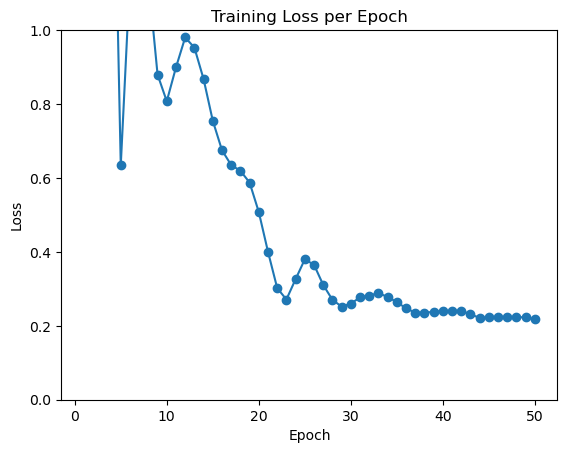

In [394]:
import matplotlib.pyplot as plt

plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title('Training Loss per Epoch')
plt.show()

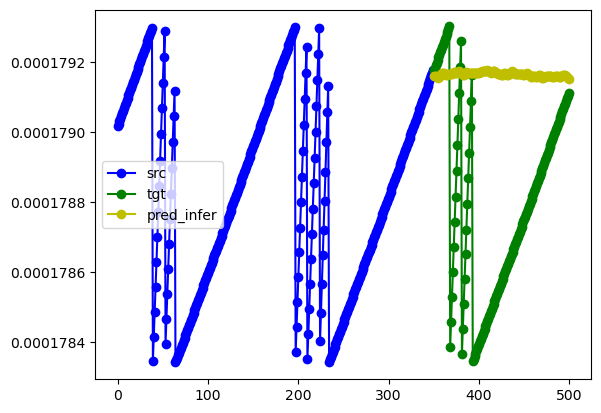

Eval Loss on test set: 0.2036
CPU times: user 56.2 s, sys: 45 s, total: 1min 41s
Wall time: 15 s


<Figure size 640x480 with 0 Axes>

In [395]:
%%time
# Evaluate model
model.eval()
eval_loss = 0.0
infer_loss = 0.0

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        src, tgt, tgt_y = split_sequence(batch[0])
        src, tgt, tgt_y = move_to_device(device, src, tgt, tgt_y)

        # [bs, tgt_seq_len, num_features]
        pred = model(src, tgt)
        loss = criterion(pred, tgt_y)
        eval_loss += loss.item()

        # Run inference with model
        pred_infer = model.infer(src, tgt.shape[1])
        loss_infer = criterion(pred_infer, tgt_y)
        infer_loss += loss_infer.item()

        if idx < NUM_VIS_EXAMPLES:
            visualize(src, tgt, pred_infer)
            # 529 visualize(src, tgt, pred, pred_infer)

avg_eval_loss = eval_loss / len(test_loader)
avg_infer_loss = infer_loss / len(test_loader)

print(f"Eval Loss on test set: {avg_eval_loss:.4f}")